# Figurs S3J, S5C, S5D, S5E
## Distribution characteristics

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Others

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-s3j_s5c_s5d_s5e.yaml'
params = uutils.load_params( params_path )

# Choices for `variant`:
# * 'wt' - Figs. S3J, S5C, S5D, S5E
variant = 'wt'

params.update( params['variants'][variant] )

Here we bake in a few defaults:

In [3]:
condition_key = params['comparison_key']
conditions = params['comparison']

group_key = params['group_key']
group_key_coreg = params['group_key_coreg']
group_key_grid = params['group_key_grid'].format( scale = params['grid_scale'] )
group_key_coreg_grid = params['group_key_coreg_grid'].format( scale = params['grid_scale'] )

keep_keys_merge_cell = [
    group_key_coreg,
    'condition',
    'dataset_id_all'
]
keep_keys_merge_grid = [
    group_key_coreg_grid,
    'condition',
    'dataset_id_all'
]

# TODO Do we need all of these?
keep_keys_responders = [
    'dataset_id',
    'dataset_id_all',
    'condition',
    'mouse',
    'fov',
    'fov_coreg',
    'slice_all',
    group_key,
    group_key_coreg,
]


# Cache defaults

if 'responders' not in params:
    params['responders'] = dict()
params['responders']['window_pre'] = params['window_pre']
params['responders']['window_post'] = params['window_post']
params['responders']['keep_keys'] = keep_keys_responders

if 'features' not in params:
    params['features'] = dict()
params['features']['window'] = params['window_pre']
params['features']['feature_keys'] = None
params['features']['keep_keys'] = keep_keys_merge_cell

if 'rates' not in params:
    params['rates'] = dict()
params['rates']['window'] = params['window_pre']
params['rates']['keep_keys'] = keep_keys_merge_cell

#### Initial setup

In [4]:
helper = Helper( config_path = params['helper_configs'],
                 hive_root = params['hive_root'],
                 output_to = params['output_parent'] )

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [5]:
grid_decorator = ('grid', params['grid_scale'], params['grid_extent'])
extra_decorators = [grid_decorator] if params['add_grid_decorator'] else []

events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = extra_decorators,
    verbose = True
)

Loading 20200810_CytoGp31m_S1_RuBiGABA1_10stim-009Cycle00001_Ch1_cell-events.mat...:   2%|▏         | 1/56 [00:00<00:06,  8.35it/s]

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:04<00:00, 11.55it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:02<00:00, 16.16it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:03<00:00, 17.31it/s] 
Grid decorators: 100%|██████████| 28/28 [00:37<00:00,  1.35s/it]



Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment Glu
    Excluded cells: 177
    Included cells: 138



In [6]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### Fig. S3J

#### Result: Histogram of post/pre relative uncaging responses (grid ROIs)

For the grid ROIs in the main figures, all events were used to determine responses (as there are fewer total events in individual grid ROIs than there are in cells.)

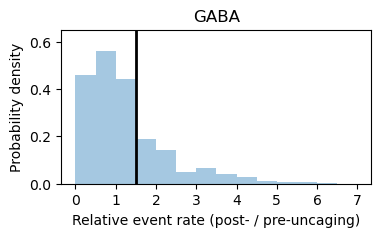

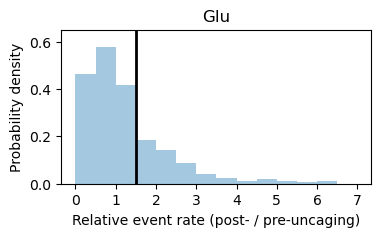

In [7]:
if 'relative_rates_grids' in params['output_names']:

    plot_params = params['plots']['relative_rates']

    # TODO Automate
    hist_bins = np.arange( 0, 7.1, 0.5 )

    for condition in conditions:
        
        color = helper.condition_colors[condition]

        #
        
        events_subset = events_analyze
        filter_condition = events_subset['condition'] == condition
        filter_neighbor = events_subset['is_uncage'] == False
        filter_cur = filter_condition & filter_neighbor
        events_cur = events_subset[filter_cur]
        responders_cur = uevents.responders(
            events_cur,
            # 'cell_global_all',
            group_key_grid,
            # Ratio is `nan` for those with 0 pre-uncaging events
            min_pre = 1,
            **params['responders']
        )
        
        #
        
        plt.figure( figsize = (4, 2) )
        
        plt.hist(
            responders_cur['ratio_post_pre'],
            bins = hist_bins,
            density = True,
            color = 'C0',
            **plot_params['hists']
        )
        
        # TODO Automate
        yl = (0, 0.65)
        plt.ylim( yl )

        plt.plot(
            params['responders']['ratio_threshold'] * np.array( [1, 1] ), yl,
            'k-',
            **plot_params['split']
        )
        
        plt.xticks( np.arange( 0, hist_bins[-1] + 1, 1. ) )

        plt.title( f'{condition}' )
        
        plt.xlabel( 'Relative event rate (post- / pre-uncaging)' )
        plt.ylabel( 'Probability density' )
        
        save_figure( params['output_names']['relative_rates_grids'] + f'-{condition}' )
        
        plt.show()

### Fig. S5C

#### Result: Scatterplots of post & pre event rates

TODO: Reduce code duplication here.

/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:428: RuntimeWarning: invalid value encountered in scalar divide
  cur_row['ratio_post_pre'] = rate_post / rate_pre
/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:428: RuntimeWarning: divide by zero encountered in scalar divide
  cur_row['ratio_post_pre'] = rate_post / rate_pre


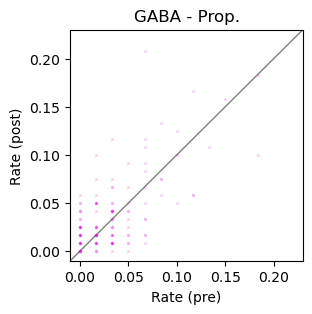

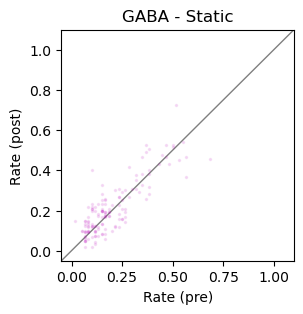

/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:428: RuntimeWarning: divide by zero encountered in scalar divide
  cur_row['ratio_post_pre'] = rate_post / rate_pre
/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:428: RuntimeWarning: invalid value encountered in scalar divide
  cur_row['ratio_post_pre'] = rate_post / rate_pre


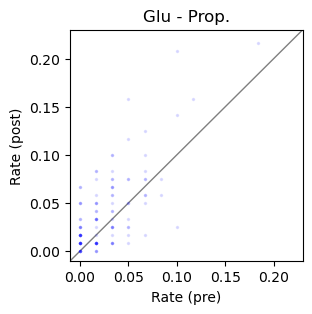

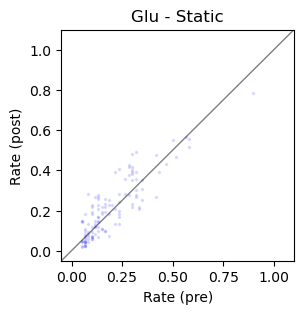

In [8]:
if 'rates' in params['output_names']:

    plot_params = params['plots']['rates']

    for condition in conditions:
        
        color = helper.condition_colors[condition]

        #
        
        events_subset = events_prop

        filter_condition = events_subset['condition'] == condition
        filter_neighbor = events_subset['is_uncage'] == False
        filter_cur = filter_condition & filter_neighbor

        events_cur = events_subset[filter_cur]

        responders_prop_cur = uevents.responders(
            events_cur,
            group_key,
            # Scatterplots also include those with no baseline events
            min_pre = 0,
            **params['responders']
        )
        
        events_subset = events_no_prop

        filter_condition = events_subset['condition'] == condition
        filter_neighbor = events_subset['is_uncage'] == False
        filter_cur = filter_condition & filter_neighbor

        events_cur = events_subset[filter_cur]

        responders_static_cur = uevents.responders(
            events_cur,
            group_key,
            # Scatterplots also include those with no baseline events
            min_pre = 0,
            **params['responders']
        )
        
        #
        
        plt.figure( figsize = plot_params['figsize'] )
        
        # TODO Automate
        xl = plot_params['xl_prop']
        yl = xl

        plt.xlim( xl )
        plt.ylim( yl )
        
        if 'unity_line' in plot_params:
            plt.plot(
                xl, xl,
                'k-',
                **plot_params['unity_line']
            )
        if 'threshold_lines' in plot_params:
            plt.plot(
                # TODO Parameterize
                [0.003, 0.003], yl,
                'k-',
                **plot_params['threshold_liens']
            )
            plt.plot(
                xl, params['ratio_threshold'] * np.array( [xl[0], xl[1]] ),
                'k-',
                **plot_params['threshold_liens']
            )

        if 'dots_responders' in plot_params:
            filter_responders = (
                (responders_prop_cur['rate_pre'] > 0.)
                & (responders_prop_cur['ratio_active'] == 1)
            )

            plt.plot(
                responders_prop_cur[~filter_responders]['rate_pre'],
                responders_prop_cur[~filter_responders]['rate_post'],
                'k.',
                **plot_params['dots']
            )
            plt.plot(
                responders_prop_cur[filter_responders]['rate_pre'],
                responders_prop_cur[filter_responders]['rate_post'],
                f'{color}.',
                **plot_params['dots_responders']
            )
        else:
            plt.plot(
                responders_prop_cur['rate_pre'],
                responders_prop_cur['rate_post'],
                f'{color}.',
                **plot_params['dots']
            )
        
        plt.title( f'{condition} - Prop.' )
        plt.xlabel( 'Rate (pre)' )
        plt.ylabel( 'Rate (post)' )
        
        save_figure( params['output_names']['rates'] + f'-prop-{condition}' )
        
        plt.show()

        #
        
        plt.figure( figsize = plot_params['figsize'] )
        
        # TODO Automate
        xl = plot_params['xl_static']
        yl = xl

        plt.xlim( xl )
        plt.ylim( yl )
        
        if 'unity_line' in plot_params:
            plt.plot(
                xl, xl,
                'k-',
                **plot_params['unity_line']
            )
        if 'threshold_lines' in plot_params:
            plt.plot(
                # TODO Parameterize
                [0.003, 0.003], yl,
                'k-',
                **plot_params['threshold_liens']
            )
            plt.plot(
                xl, params['ratio_threshold'] * np.array( [xl[0], xl[1]] ),
                'k-',
                **plot_params['threshold_liens']
            )

        if 'dots_responders' in plot_params:
            filter_responders = (
                (responders_static_cur['rate_pre'] > 0.)
                & (responders_static_cur['ratio_active'] == 1)
            )

            plt.plot(
                responders_static_cur[~filter_responders]['rate_pre'],
                responders_static_cur[~filter_responders]['rate_post'],
                'k.',
                **plot_params['rates']['dots']
            )
            plt.plot(
                responders_static_cur[filter_responders]['rate_pre'],
                responders_static_cur[filter_responders]['rate_post'],
                f'{color}.',
                **plot_params['dots_responders']
            )
        else:
            plt.plot(
                responders_static_cur['rate_pre'],
                responders_static_cur['rate_post'],
                f'{color}.',
                **plot_params['dots']
            )
        
        plt.title( f'{condition} - Static' )
        plt.xlabel( 'Rate (pre)' )
        plt.ylabel( 'Rate (post)' )
        
        save_figure( params['output_names']['rates'] + f'-static-{condition}' )
        
        plt.show()

***

### Figs. S3J, S5D

#### Result: Histograms of post/pre relative uncaging responses

In [9]:
if 'relative_rates' in params['output_names']:

    plot_params = params['plots']['relative_rates']

    # TODO Automate
    hist_bins = np.arange( 0, 6.1, 0.25 )

    for condition in conditions:
        
        color = helper.condition_colors[condition]

        #
        
        events_subset = events_prop
        filter_condition = events_subset['condition'] == condition
        filter_neighbor = events_subset['is_uncage'] == False
        filter_cur = filter_condition & filter_neighbor
        events_cur = events_subset[filter_cur]
        responders_prop_cur = uevents.responders(
            events_cur,
            group_key,
            # Ratio is `nan` for those with 0 pre-uncaging events
            min_pre = 1,
            **params['responders']
        )
        
        events_subset = events_no_prop
        filter_condition = events_subset['condition'] == condition
        filter_neighbor = events_subset['is_uncage'] == False
        filter_cur = filter_condition & filter_neighbor
        events_cur = events_subset[filter_cur]
        responders_no_prop_cur = uevents.responders(
            events_cur,
            group_key,
            # Ratio is `nan` for those with 0 pre-uncaging events
            min_pre = 1,
            **params['responders']
        )
        
        #
        
        plt.figure( figsize = (4, 2) )
        
        plt.hist(
            responders_no_prop_cur['ratio_post_pre'],
            bins = hist_bins,
            density = True,
            color = 'C0',
            label = 'Static',
            **plot_params['hists']
        )
        plt.hist(
            responders_prop_cur['ratio_post_pre'],
            bins = hist_bins,
            density = True,
            color = 'C1',
            label = 'Prop.',
            **plot_params['hists']
        )
        
        # TODO Automate
        yl = (0, 1.25)
        plt.ylim( yl )

        plt.plot(
            params['responders']['ratio_threshold'] * np.array( [1, 1] ), yl,
            'k-',
            **plot_params['split']
        )
        
        plt.title( f'{condition}' )
        plt.legend()
        
        plt.xlabel( 'Relative event rate (post- / pre-uncaging)' )
        plt.ylabel( 'Probability density' )
        
        save_figure( f'event-ratio-histogram-cells-{condition}' )
        
        plt.show()

***

### Fig. S5E

#### Setup

In [10]:
cell_key = params['group_key']

events_considered_features = events_analyze.copy()
events_considered_response = events_prop.copy()
events_considered_static = events_no_prop.copy()

In [11]:
filter_events_condition_features = events_considered_features[condition_key].isin( conditions )
filter_events_neighbor_features = events_considered_features['is_uncage'] == False
filter_events_panel_features = filter_events_condition_features & filter_events_neighbor_features

events_panel_features = events_considered_features[filter_events_panel_features]

filter_events_condition_response = events_considered_response[condition_key].isin( conditions )
filter_events_neighbor_response = events_considered_response['is_uncage'] == False
filter_events_panel_response = filter_events_condition_response & filter_events_neighbor_response

events_panel_response = events_considered_response[filter_events_panel_response]

filter_events_condition_static = events_considered_static[condition_key].isin( conditions )
filter_events_neighbor_static = events_considered_static['is_uncage'] == False
filter_events_panel_static = filter_events_condition_static & filter_events_neighbor_static

events_panel_static = events_considered_static[filter_events_panel_static]

#

events_panel_kinds = {
    'predict': events_panel_features,
    'response': events_panel_response,
    'static': events_panel_static,
}

### Run

In [12]:
results_features = uevents.features(
    events_panel_features,
    group_key,
    **params['features']
)

results_rates = uevents.rates(
    events_panel_kinds,
    group_key,
    **params['rates']
)

/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:504: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )


In [13]:
# Filter only those with baseline response-type (propagative) events

filter_use = results_rates['rate_response'] > 0.
groups_use = results_rates[filter_use][cell_key]

filter_groups_features = results_rates[cell_key].isin( groups_use )
filter_groups_rates = results_rates[cell_key].isin( groups_use )

results_features = results_features[filter_groups_features]
results_rates = results_rates[filter_groups_rates]

#### Result: Histogram of baseline propagative fraction

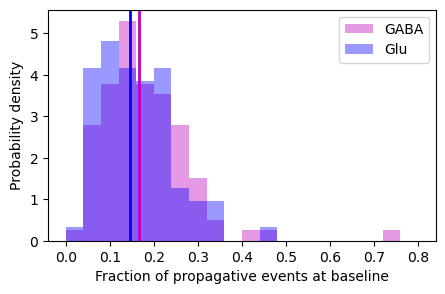

In [14]:
cur_params = params['plots']['baseline_prop_fraction']

prediction_key = 'mark_propTotal_bin'
hist_bins = np.arange( 0, 0.81, 0.04 )

plt.figure( figsize = cur_params['figsize'] )

for condition in conditions:
    
    color = helper.condition_colors[condition]
    
    filter_condition = results_features['condition'] == condition
    results_condition = results_features[filter_condition]

    plt.hist(
        results_condition[prediction_key],
        density = True,
        bins = hist_bins,
        color = color,
        label = condition,
        **cur_params['hists']
    )
    
yl = plt.ylim()
    
for condition in conditions:
    
    color = helper.condition_colors[condition]
    
    filter_condition = results_features['condition'] == condition
    results_condition = results_features[filter_condition]
    
    cur_threshold = np.quantile( results_condition[prediction_key], params['quantile_split'] )
    
    plt.plot(
        [cur_threshold, cur_threshold], yl,
        f'{color}-',
        **cur_params['split']
    )

plt.ylim( yl )
    
plt.xlabel( 'Fraction of propagative events at baseline' )
plt.ylabel( 'Probability density' )

plt.legend()

save_figure( params['output_names']['baseline_prop_fraction'] )

plt.show()

### Result: Histogram of baseline overall event rate

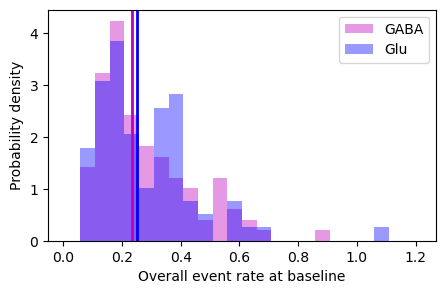

In [15]:
cur_params = params['plots']['relative_rates']

prediction_key = 'rate_predict'
hist_bins = np.arange( 0.5 / 60, 75.5 / 60, 3 / 60 )

plt.figure( figsize = (5, 3) )

for condition in conditions:
    
    color = helper.condition_colors[condition]
    
    filter_condition = results_rates['condition'] == condition
    results_condition = results_rates[filter_condition]

    plt.hist( results_condition[prediction_key],
              density = True,
              bins = hist_bins,
              color = color,
              label = condition,
              **cur_params['hists'] )
    
yl = plt.ylim()
    
for condition in conditions:
    
    color = helper.condition_colors[condition]
    
    filter_condition = results_rates['condition'] == condition
    results_condition = results_rates[filter_condition]
    
    cur_threshold = np.quantile( results_condition[prediction_key], params['quantile_split'] )
    
    plt.plot(
        [cur_threshold, cur_threshold], yl,
        f'{color}-',
        **cur_params['split']
    )

plt.ylim( yl )
    
plt.xlabel( 'Overall event rate at baseline' )
plt.ylabel( 'Probability density' )

plt.legend()

save_figure( params['output_names']['baseline_rate_overall'] )

plt.show()